In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

import zfpy
import numpy as np
import copy
from src.zfp_model_compress import zfp_compress_model, zfp_decompress_model

# 1. Fine-Tune Model for CIFAR-10
Resnet-18 was initially trained on ImageNet

In [2]:
# Prep Benchmark CIFAR-10 dataset to feed into ResNet 18
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match ResNet-18's expected input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalize with CIFAR-10 mean and std
])

In [3]:
# Load the CIFAR-10 test dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [39]:
#Load Pretrained Resnet18
model = resnet18(pretrained=True)

#Redefine last layer to work with CIFAR-10's num_classes
model.fc= nn.Linear(model.fc.in_features, out_features=10)

#Change if running on Kaggle or HPC3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
print()

/Users/ajaxcarroway/Desktop/College Stuff/CS 190/eblc-model-compression/esdenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ajaxcarroway/Desktop/College Stuff/CS 190/eblc-model-compression/esdenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#Conduct Fine-Tuning
loss_per_epoch = []
num_epochs=10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(total=num_epochs) as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)
        loss_per_epoch.append(epoch_loss)
        pbar.update(1)
        print(f'Loss: {epoch_loss:.4f}')

  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

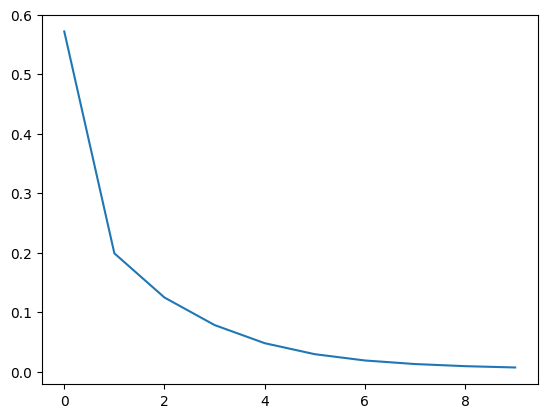

In [8]:
# Visualize Loss and Save Fine-Tuned Model
plt.plot(loss_per_epoch)
torch.save(model.state_dict(), 'resnet18_weights.pth')

# 2. Apply ZFP to Resnet-18 Fine-Tuned Model


In [40]:
# Load fine-tuned model from .pth checkpoint
model = resnet18()
model.fc= nn.Linear(model.fc.in_features, out_features=10)
state_dict = torch.load("models/resnet18_weights.pth", map_location=device)
incompatible_keys = model.load_state_dict(state_dict)


In [41]:
# Apply Compression
zfp_compress_model(model)
compressed_weights = torch.load("models/resnet18_weights_compressed.pth", map_location=device)
state_dict = zfp_decompress_model(compressed_weights)

In [43]:
# Ensure weights are slightly different (If using lossy zfp)
print(f"Compressed: \n{state_dict['conv1.weight'][0][0]}")
print(f"Original: \n{model.state_dict()['conv1.weight'][0][0]}")

Compressed: 
tensor([[-0.0111, -0.0088, -0.0040,  0.0733,  0.0556,  0.0152, -0.0149],
        [ 0.0153,  0.0117, -0.1075, -0.2770, -0.2676, -0.1270,  0.0053],
        [-0.0017,  0.0622,  0.2990,  0.5909,  0.5235,  0.2588,  0.0659],
        [ 0.0317, -0.0684, -0.2997, -0.4391, -0.2712, -0.0019,  0.0563],
        [-0.0276,  0.0134,  0.0704, -0.0561, -0.3341, -0.4229, -0.2604],
        [ 0.0302,  0.0381,  0.0603,  0.2370,  0.4121,  0.3910,  0.1634],
        [-0.0140, -0.0062, -0.0265, -0.0682, -0.1522, -0.0848, -0.0079]])
Original: 
tensor([[-0.0111, -0.0089, -0.0040,  0.0733,  0.0556,  0.0152, -0.0149],
        [ 0.0153,  0.0117, -0.1075, -0.2770, -0.2676, -0.1270,  0.0053],
        [-0.0017,  0.0622,  0.2990,  0.5908,  0.5235,  0.2588,  0.0659],
        [ 0.0317, -0.0683, -0.2997, -0.4391, -0.2712, -0.0019,  0.0563],
        [-0.0276,  0.0134,  0.0704, -0.0561, -0.3340, -0.4229, -0.2604],
        [ 0.0302,  0.0382,  0.0603,  0.2370,  0.4121,  0.3910,  0.1634],
        [-0.0140, -0.0062,

# 3. Evaluate Both Models
Using CIFAR-10 test dataset as the benchmark eval dataset

In [44]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified


In [29]:
def accuracy(model, test_loader, device=device):
    correct = 0
    total = 0
    total_iterations = len(test_loader)

    with torch.no_grad():  # Disable gradient computation for evaluation
        with tqdm(total=total_iterations) as pbar:
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if(total % 10 == 0):
                    pbar.update(1)

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the CIFAR-10 test images: {accuracy:.2f}%')

In [ ]:
compressed_model = resnet18()
compressed_model.fc= nn.Linear(compressed_model.fc.in_features, out_features=10)
compressed_model.load_state_dict(state_dict)

In [53]:
accuracy(model, test_loader, device)
accuracy(compressed_model, test_loader, device)

  2%|▏         | 2/100 [00:15<12:24,  7.59s/it]


KeyboardInterrupt: 